In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy import interpolate
from matplotlib.gridspec import GridSpec
import matplotlib
from scipy.optimize import curve_fit
%config InlineBackend.figure_format = 'retina'

In [2]:
def extract_best_xy(file_path):
    best_x_values = []
    best_y_values = []
    
    # open the file and read by line
    with open(file_path, 'r') as f:
        for line in f:
            # use regular expressions to extract Best_x and Best_y
            best_x_match = re.search(r'Best_x = \[(.*?)\]', line)
            best_y_match = re.search(r'Best_y = ([\d\.eE+-]+)', line)
            
            if best_x_match and best_y_match:
                # extract and parse Best_x
                best_x = [float(x) for x in best_x_match.group(1).split()]
                best_y = float(best_y_match.group(1))
                
                best_x_values.append(best_x)
                best_y_values.append(best_y)
    
    return best_x_values, best_y_values


In [3]:
file_path = '0316_new_uni.txt'

In [4]:
best_x, best_y = extract_best_xy(file_path)

In [5]:
np.min(best_y)

2.103436374431433

In [6]:
best_x[np.argmin(best_y)]

[142.349757, 0.349616882, 1209.70059, 78.6641791]

In [7]:
def extract_d_c(solu, times):
    """
    To extract the dispersion curve from the result of Comsol.
    :param solu: the freq_velocity matrix.
    :param times: decrease the y scale (velocity) to make sure measure distance
    :return: single freq_velocity dispersion curve and matrix which minus the single dispersion curve.
    """
    single_solu = []

    k = np.argmin(solu[:, 0])
    single_solu.append(solu[k])
    while True:
        solu = np.delete(solu, k, axis = 0)

        dis_arr = []  # creating the distancing array to find the min distance from the single_solu[-1]

        for i in range(len(solu)):
            if solu[i, 1] <= single_solu[-1][1] + 0.01:  # to ensure that the phase velocity decrease in single mode
                dis_arr.append(20 * (solu[i, 0] - single_solu[-1][0]) ** 2 + (solu[i, 1] - single_solu[-1][1]) ** 2)
                # the meaning of 20 is adding weight of distance of frequency
            else:
                dis_arr.append(99999999999)
        if not dis_arr or min(dis_arr) == 99999999999:
            print(single_solu[-1][0])  # to check whether the freq of single mode reach the required freq
            break
        k = dis_arr.index(min(dis_arr))
        single_solu.append(solu[k])

    single_solu = np.array(single_solu)
    single_solu[:, 1] = times * single_solu[:, 1]  # recover the dispersion curves (velocity values)
    last_solu = solu
    return single_solu, last_solu

In [8]:
df = pd.read_csv('0328_uni.txt',sep = '\t')

In [9]:
c = 2 * np.pi* df['real(freq) (Hz)'][25::]/df['kx (1/m)'][25::]

In [10]:
funda_mode = pd.read_excel('fundamental_mode.xlsx')
frist_mode = pd.read_excel('1st_mode_2.xlsx')

In [11]:
solu_ma = np.vstack((df['real(freq) (Hz)'][25::], c)).T

In [12]:
arr = []
for i in range(len(solu_ma)):
    if solu_ma[i, 1] > 1900 or solu_ma[i, 0] > 25:
        arr.append(i)
solu_ma = np.delete(solu_ma, arr, axis=0)

In [13]:
times = 50
solu_ma[:, 1] = solu_ma[:, 1] / times
fund_solu, last_solu = extract_d_c(solu_ma, times)
sec_solu, last_solu = extract_d_c(last_solu, times)

24.595
24.002


In [14]:
solu_list = [fund_solu, sec_solu]
df_list = [funda_mode, frist_mode]

fnew_list = []
vnew_list = []

for solu, df_item in zip(solu_list, df_list):
    f = interpolate.interp1d(solu[:, 0], solu[:, 1], kind=2, fill_value="extrapolate")
    fnew = df_item['X']

    vnew = f(fnew)

    fnew_list.append(fnew)
    vnew_list.append(vnew)

cal_1 = np.vstack((fnew_list[0], vnew_list[0])).T
cal_2 = np.vstack((fnew_list[1], vnew_list[1])).T

freq_map_0 = {freq: idx for idx, freq in enumerate(df_list[0]['X'])}
freq_map_1 = {freq: idx for idx, freq in enumerate(df_list[1]['X'])}

In [15]:
def error_velocity(cal, freq_map, velocity_data):
    """
    calculate the error velocity for the same frequency
    :param cal: calculation DS [samples,2], first column is freq
    second column is velocity
    :param freq_map: mapping the freq of observation DS
    :param velocity_data: velocity of observation DS
    :return:
    """
    obj_v = 0
    for x, y in cal:
        j = freq_map[x]
        obj_v += np.abs(velocity_data.iloc[j] - y)/velocity_data.iloc[j]
    return obj_v

In [16]:
obj_v1 = error_velocity(cal_1, freq_map_0, df_list[0]['Y'])
obj_v2 = error_velocity(cal_2, freq_map_1, df_list[1]['Y'])
obj = (obj_v1 + obj_v2)
obj

2.1045035239774785

In [17]:
property_values = best_y
misfits = best_y

# set the color mapping
norm = Normalize(vmin=np.min(misfits), vmax=np.max(misfits))  # set the range of color mapping
cmap = plt.cm.viridis  # using viridis map the color

In [18]:
def generate_velocity_profile(a1, m1, v2, h1):
    """
    generare 1-d shear wave velocity profile
    
    parameters:
        a1: velocity increasing coeff
        m1: power low coeff
        h1: depth boundary between layers
        v2: initial velocity
    returns:
        h: array of depth values
        v: corresponding velocity values at each depth
    """
    h = np.arange(1, 100 + 0.2, 0.2)  # depth range from 0 to 100 with 0.5 intervel
    v = np.zeros_like(h, dtype=float)    # initial the velocity array

    h2 = 100-3-h1
    # calculate velocity for two depth regions
    for i, depth in enumerate(h):
        if 0 <= depth <= h2:
            v[i] = a1 * (depth ** m1)  # first region
        elif h2 < depth <= 100:
            v[i] = v2  # second region
    indices = np.where(h <= h2)
    v1,h1 = v[indices],h[indices]
    v3,h3 = v[indices[0][-1]+1::],h[indices[0][-1]+1::]
    
    return np.concatenate([h1,[h1[-1]],h3]),np.concatenate([v1,[v2],v3])

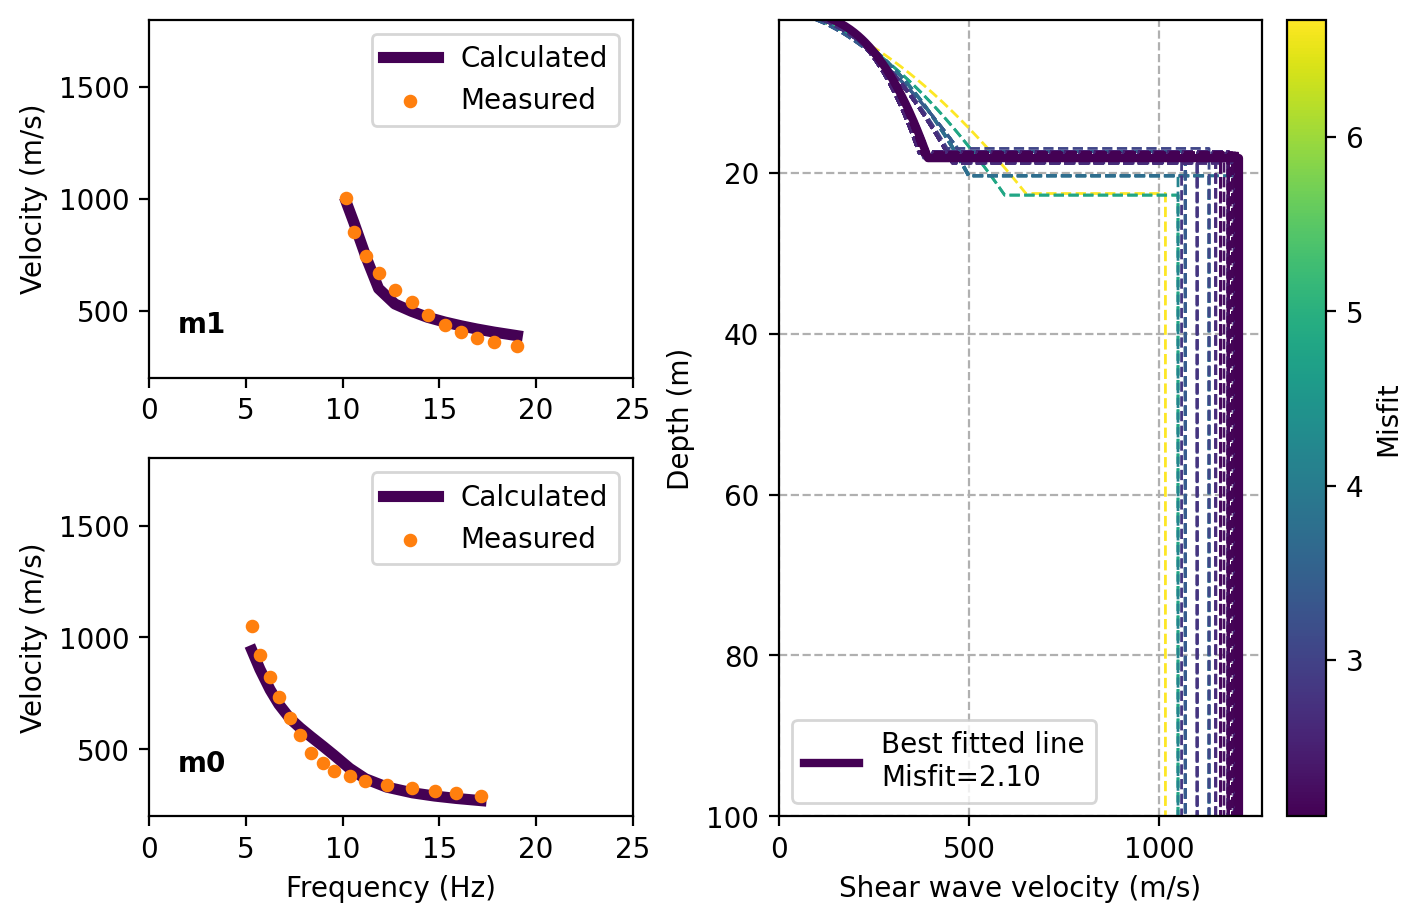

In [19]:
fig = plt.figure(layout="constrained",figsize = (7,4.5))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
max_color = matplotlib.colormaps['viridis'](0)
ax1.plot(cal_2[:,0], cal_2[:,1],c = max_color, lw = 4, label = 'Calculated')
ax1.scatter(frist_mode['X'], frist_mode['Y'],marker = "o",c = '#ff7f0e',s = 15, zorder = 3,label = 'Measured')
ax1.set_xlim(0,25)
ax1.set_ylim(200,1800)
ax1.text(1.5,400,'m1',weight = 'bold')  
ax1.set_ylabel('Velocity (m/s)')  

ax1.legend()


ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(cal_1[:,0], cal_1[:,1], c=max_color, lw = 4, label = 'Calculated')
ax2.scatter(funda_mode['X'], funda_mode['Y'],marker = "o",c = '#ff7f0e',s = 15, zorder = 3,label = 'Measured')
ax2.set_xlim(0,25)
ax2.set_ylim(200,1800)
ax2.set_xlabel('Frequency (Hz)')  
ax2.set_ylabel('Velocity (m/s)')  

ax2.text(1.5,400,'m0',weight = 'bold')  

ax2.legend()

ax3 = fig.add_subplot(gs[:, 1])


for prop, misfit in zip(best_x, misfits):
    color = cmap(norm(np.mean(misfit)))
    a1, m1, v2, h1 = prop
    h, v = generate_velocity_profile(a1, m1, v2, h1)
    ax3.plot(v, h, color=color, linewidth=1,ls = '--')

####### best fit line

a1, m1, v2, h1 = best_x[np.argmin(best_y)]
h, v = generate_velocity_profile(a1, m1, v2, h1)
ax3.plot(v, h, color=max_color, linewidth=3,label = 'Best fitted line\nMisfit=2.10')

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax3)
cbar.set_label('Misfit')

ax3.set_ylabel('Depth (m)')

ax3.legend()
ax3.grid(ls='--')
ax3.set_ylim(1, 100)
ax3.set_xlim(0, )
ax3.set_xlabel('Shear wave velocity (m/s)')
ax3.invert_yaxis()

# fig.savefig('ds_vs_uni.png', dpi=600,bbox_inches = 'tight')

# plt.tight_layout()
plt.show()